A long standing dependency of [MotionClouds](https://neuralensemble.github.io/MotionClouds/) is MayaVi. While powerful, it is tedious to compile and may discourage new users. We are trying here to show some attempts to do the same with the [vispy](http://vispy.org) library.

In [another post](https://laurentperrinet.github.io/sciblog/posts/2014-10-08_moving-from-mayavi-to-matplotlib.html), we tried to use matplotlib, but this had some limitations. Let's now try [vispy](http://vispy.org), a scientific visualisation library in python using opengl.

<!-- TEASER_END -->

VisPy is a quite young library, with a mature mid-level object-otriented wrapper to openGL (that they called ``gloo``, I guess it is GL object-oriented) and the early stages of a high-level wrapper quite similar to MayaVi in the functioanlity. As I do not need to mess with the GPU, I will use the latter. As for the time being, we need to install the latest version:

In [1]:
#!pip install vispy
!pip install git+https://github.com/vispy/vispy.git

  Cloning https://github.com/vispy/vispy.git to /var/folders/ry/dtnlx8yn3cd15d0t5kf24fr00000gp/T/pip-SoPx1Q-build


In particular, it has a [IsoSurface](http://api.vispy.org/en/latest/scene.html?highlight=isosurface#vispy.scene.visuals.Isosurface) object:

In [2]:
%%writefile /tmp/isosurface.py
import sys
import numpy as np

from vispy import app, scene

import numpy as np

from vispy import gloo
from vispy import app
from vispy.util.transforms import perspective, translate, rotate
from vispy.io import load_data_file

#app.use_app('ipynb_webgl')
app.use_app('pyglet')

# Create a canvas with a 3D viewport
canvas = scene.SceneCanvas(keys='interactive')
view = canvas.central_widget.add_view()

## Define a scalar field from which we will generate an isosurface
def psi(i, j, k, offset=(25, 25, 50)):
    x = i-offset[0]
    y = j-offset[1]
    z = k-offset[2]
    th = np.arctan2(z, (x**2+y**2)**0.5)
    r = (x**2 + y**2 + z**2)**0.5
    a0 = 1
    ps = ((1./81.) * 1./(6.*np.pi)**0.5 * (1./a0)**(3/2) * (r/a0)**2 *
          np.exp(-r/(3*a0)) * (3 * np.cos(th)**2 - 1))
    return ps

print("Generating scalar field..")
data = np.abs(np.fromfunction(psi, (50, 50, 100)))

# Create isosurface visual
surface = scene.visuals.Isosurface(data, level=data.max()/4.,
                                   color=(0.5, 0.6, 1, .3), shading='smooth',
                                   parent=view.scene)
surface.transform = scene.transforms.STTransform(translate=(-25, -25, -50))

# Add a 3D axis to keep us oriented
axis = scene.visuals.XYZAxis(parent=view.scene)

# Use a 3D camera
# Manual bounds; Mesh visual does not provide bounds yet
# Note how you can set bounds before assigning the camera to the viewbox
cam = scene.TurntableCamera(elevation=30, azimuth=30)
cam.set_range((-10, 10), (-10, 10), (-10, 10))
view.camera = cam

canvas.show()
if sys.flags.interactive == 0:
    app.run()

Overwriting /tmp/isosurface.py


The goal is to give a synthetic representation of a Motion Clouds in the Fourier and euclidian domains both in space and time.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import MotionClouds as mc
fx, fy, ft = mc.get_grids(mc.N_X, mc.N_Y, mc.N_frame)
color = mc.envelope_color(fx, fy, ft) #

name = 'test'
z = color * mc.envelope_gabor(fx, fy, ft)
mc.figures(z, name)
mc.in_show_video(name)
im_mc =  mc.rectif(mc.random_cloud(z))

[ 13 %] Time elapsed: 00:00:00 | ETA: 00:00:01

Saving sequence ../files/test as a .mp4 format


[100 %] Time elapsed: 00:00:01 | ETA: 00:00:00
Total time elapsed: 00:00:01


Title: 
  Started: 06/25/2016 09:14:32
  Finished: 06/25/2016 09:14:34
  Total time elapsed: 00:00:01
  CPU %: 104.70
  Memory %: 4.16


 to display the Fourier envelope:

In [5]:
%%writefile /tmp/isosurface_mc.py
import sys
import numpy as np

import MotionClouds as mc
fx, fy, ft = mc.get_grids(mc.N_X, mc.N_Y, mc.N_frame)
color = mc.envelope_color(fx, fy, ft) #
z = color * mc.envelope_gabor(fx, fy, ft, B_V=0.05, B_theta=np.pi/2)

from vispy import app, scene
app.use_app('pyglet')

# Create a canvas with a 3D viewport
canvas = scene.SceneCanvas(keys='interactive', position = (0, 0), bgcolor='white')
view = canvas.central_widget.add_view()

#frame = scene.visuals.Cube(size = (mc.N_X/2, mc.N_Y/2, mc.N_frame/2), color=None,
#                                   edge_color=(0., 0., 0., 1.), 
#                                   parent=view.scene)

# Create isosurface visual
#volume = scene.visuals.Volume(z/z.max(), parent=frame, emulate_texture=True)
center = scene.transforms.STTransform(translate=(-mc.N_X/2, -mc.N_Y/2, -mc.N_frame/2))
#volume.transform = center
#volume.cmap = 'blues'


surface = scene.visuals.Isosurface(z, level=z.max()/4.,
                                   color=(0.5, 0.6, 1, .3), shading='smooth',
                                   parent=view.scene)
surface.transform = center

# Add a 3D axis to keep us oriented
axis = scene.visuals.XYZAxis(parent=view.scene)

# Use a 3D camera
# Manual bounds; Mesh visual does not provide bounds yet
# Note how you can set bounds before assigning the camera to the viewbox
cam = scene.TurntableCamera(elevation=30, azimuth=30)
cam.set_range((-mc.N_X/2, mc.N_X/2), (-mc.N_Y/2, mc.N_Y/2), (-mc.N_frame/2, mc.N_frame/2))
view.camera = cam

canvas.show()
if sys.flags.interactive == 0:
    app.run()

Overwriting /tmp/isosurface_mc.py


Let's render this scene offline as it makes it easier to see in the notebook:

In [6]:
import numpy as np
np.set_printoptions(precision=3, suppress=True)
from vispy import app, scene
from vispy.util.transforms import perspective, translate, rotate
app.use_app('pyglet')

canvas = scene.SceneCanvas(keys='interactive', size =(1280, 1024), position = (0, 0), bgcolor='white', dpi=450)
view = canvas.central_widget.add_view()

surface = scene.visuals.Isosurface(z, level=z.max()/4.,
                                   color=(0.5, 0.6, 1, .3), shading='smooth',
                                   parent=view.scene)
surface.transform = scene.transforms.STTransform(translate=(-mc.N_X/2, -mc.N_Y/2, -mc.N_frame/2))

axis = scene.visuals.XYZAxis(parent=view.scene)

cam = scene.TurntableCamera(elevation=30, azimuth=30)
cam.set_range((-mc.N_X/2, mc.N_X/2), (-mc.N_Y/2, mc.N_Y/2), (-mc.N_frame/2, mc.N_frame/2))
view.camera = cam

# The rendering is done, we get the rendering output (4D NumPy array)
im = canvas.render()

Let's test rendering with MatPlotLib:

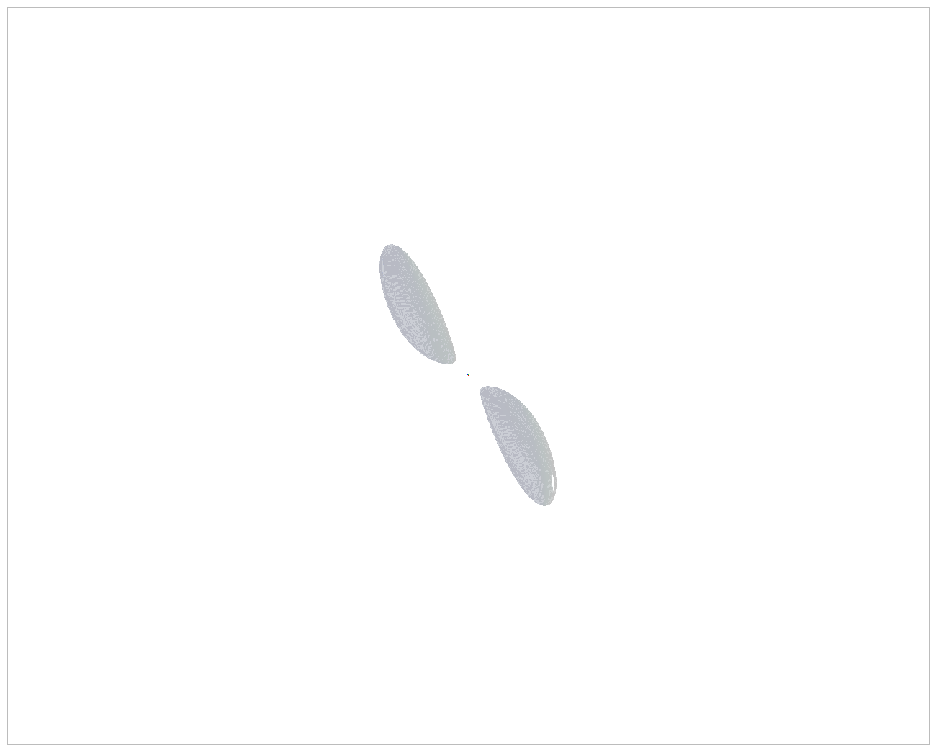

In [7]:
import pylab
import matplotlib.pyplot as plt
%matplotlib inline
# Now, we display this image with matplotlib to check.
def im2plt(im):
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(12.8, 10.24), dpi=450)
    ax = fig.add_axes([0., 0., 1., 1.], axisbg='w')
    plt.setp(ax, xticks=[])
    plt.setp(ax, yticks=[])
    #ax.axis(c='b', lw=0, frame_on=False)
    ax.imshow(im, interpolation='none')
    ax.grid(b=False, which="both")
im2plt(im)

It's easy (and more accurate) to render the scene offline to a graphics file and then to display the image.

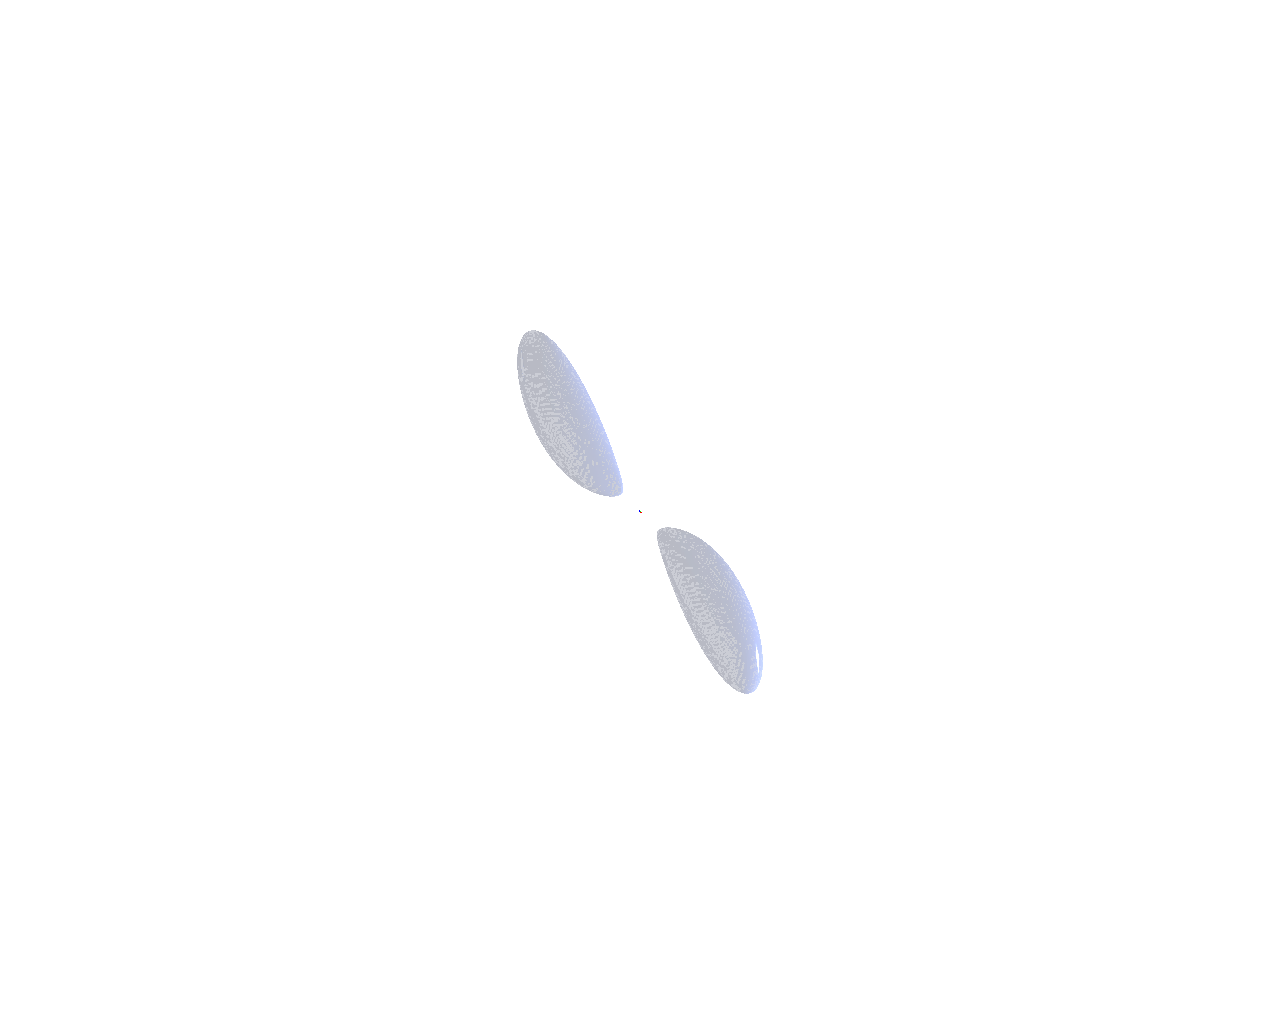

In [8]:
def im2img(im):
    # create a temporary file
    import tempfile
    filename = tempfile.mktemp(suffix='.png')
    # Use write_png to export your wonderful plot as png ! 
    import vispy.io as io
    io.write_png(filename, im)
    from IPython.display import Image
    return Image(filename)
im2img(im)

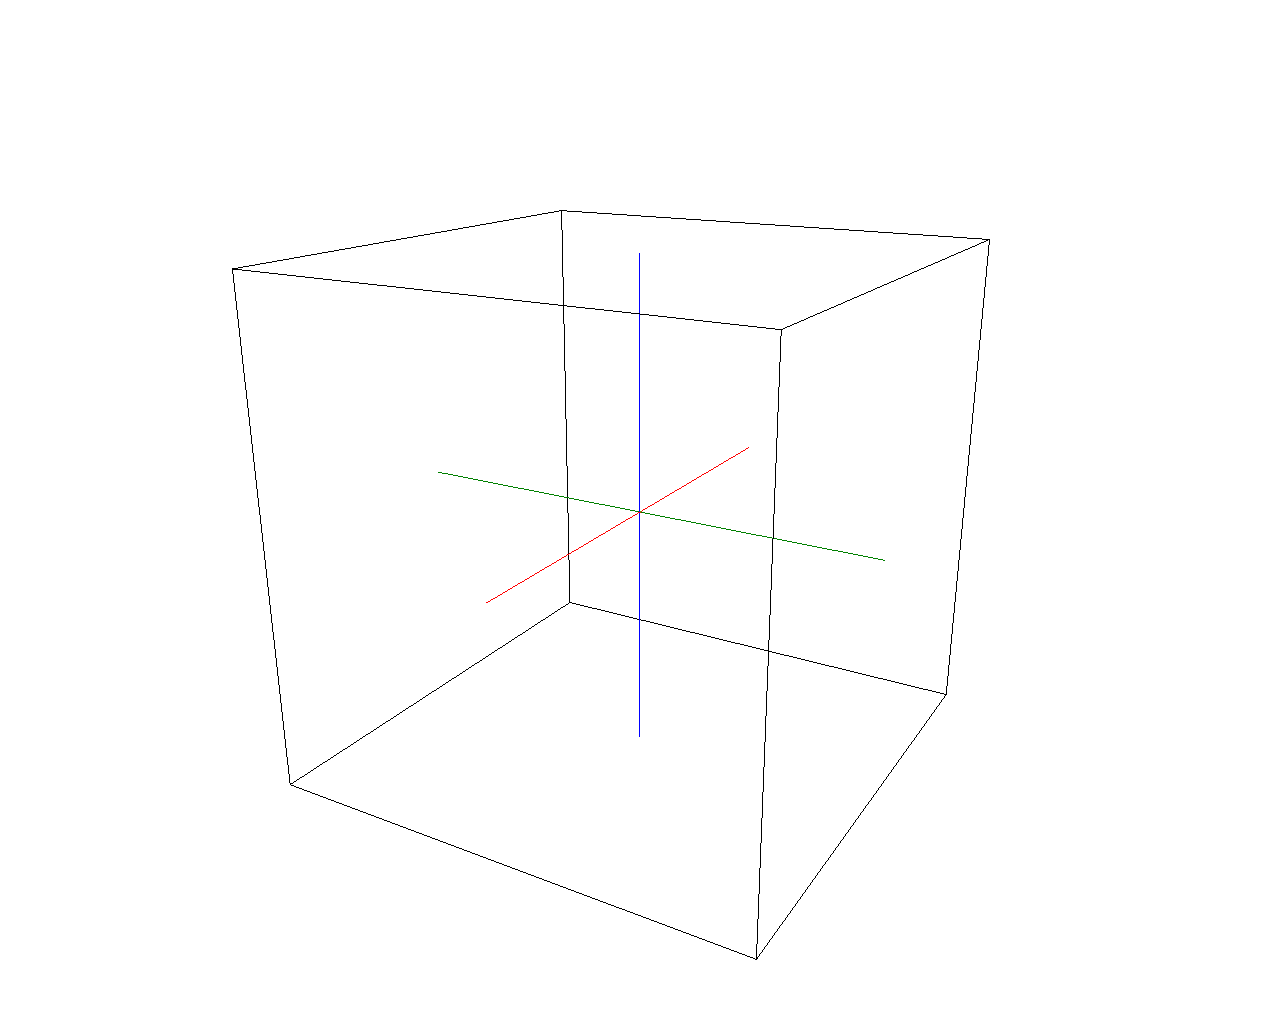

In [9]:
from vispy import app, scene
from vispy.util.transforms import perspective, translate, rotate

canvas = scene.SceneCanvas(keys='interactive', size =(1280, 1024), position = (0, 0), bgcolor='white', dpi=450)

view = canvas.central_widget.add_view()

N_X, N_Y, N_frame= mc.N_X, mc.N_Y, mc.N_frame

axis = scene.visuals.XYZAxis(parent=view.scene)
for p in ([1, 1, 1, -1, 1, 1], [1, 1, -1, -1, 1, -1], [1, -1, 1, -1, -1, 1],[1, -1, -1, -1, -1, -1], 
          [1, 1, 1, 1, -1, 1], [-1, 1, 1, -1, -1, 1], [1, 1, -1, 1, -1, -1], [-1, 1, -1, -1, -1, -1], 
          [1, 1, 1, 1, 1, -1], [-1, 1, 1, -1, 1, -1], [1, -1, 1, 1, -1, -1], [-1, -1, 1, -1, -1, -1]):
    line = scene.visuals.Line(pos=np.array([[p[0]*N_X/2, p[1]*N_Y/2, p[2]*N_frame/2], [p[3]*N_X/2, p[4]*N_Y/2, p[5]*N_frame/2]]), color='black', parent=view.scene)

axisX = scene.visuals.Line(pos=np.array([[0, -N_Y/2, 0], [0, N_Y/2, 0]]), color='red', parent=view.scene)
axisY = scene.visuals.Line(pos=np.array([[-N_X/2, 0, 0], [N_X/2, 0, 0]]), color='green', parent=view.scene)
axisZ = scene.visuals.Line(pos=np.array([[0, 0, -N_frame/2], [0, 0, N_frame/2]]), color='blue', parent=view.scene)


cam = scene.TurntableCamera(elevation=20, azimuth=30)
cam.fov = 45
cam.scale_factor = mc.N_X * 2.
cam.set_range((-mc.N_X/2, mc.N_X/2), (-mc.N_Y/2, mc.N_Y/2), (-mc.N_frame/2, mc.N_frame/2))
view.camera = cam
#view.set_camera('turntable', mode='perspective', up='z', distance=2,
#                azimuth=30., elevation=30.)
# The rendering is done, we get the rendering output (4D NumPy array)
# Use render to generate an image object
im = canvas.render()
im2img(im)

Now a more complete scene:

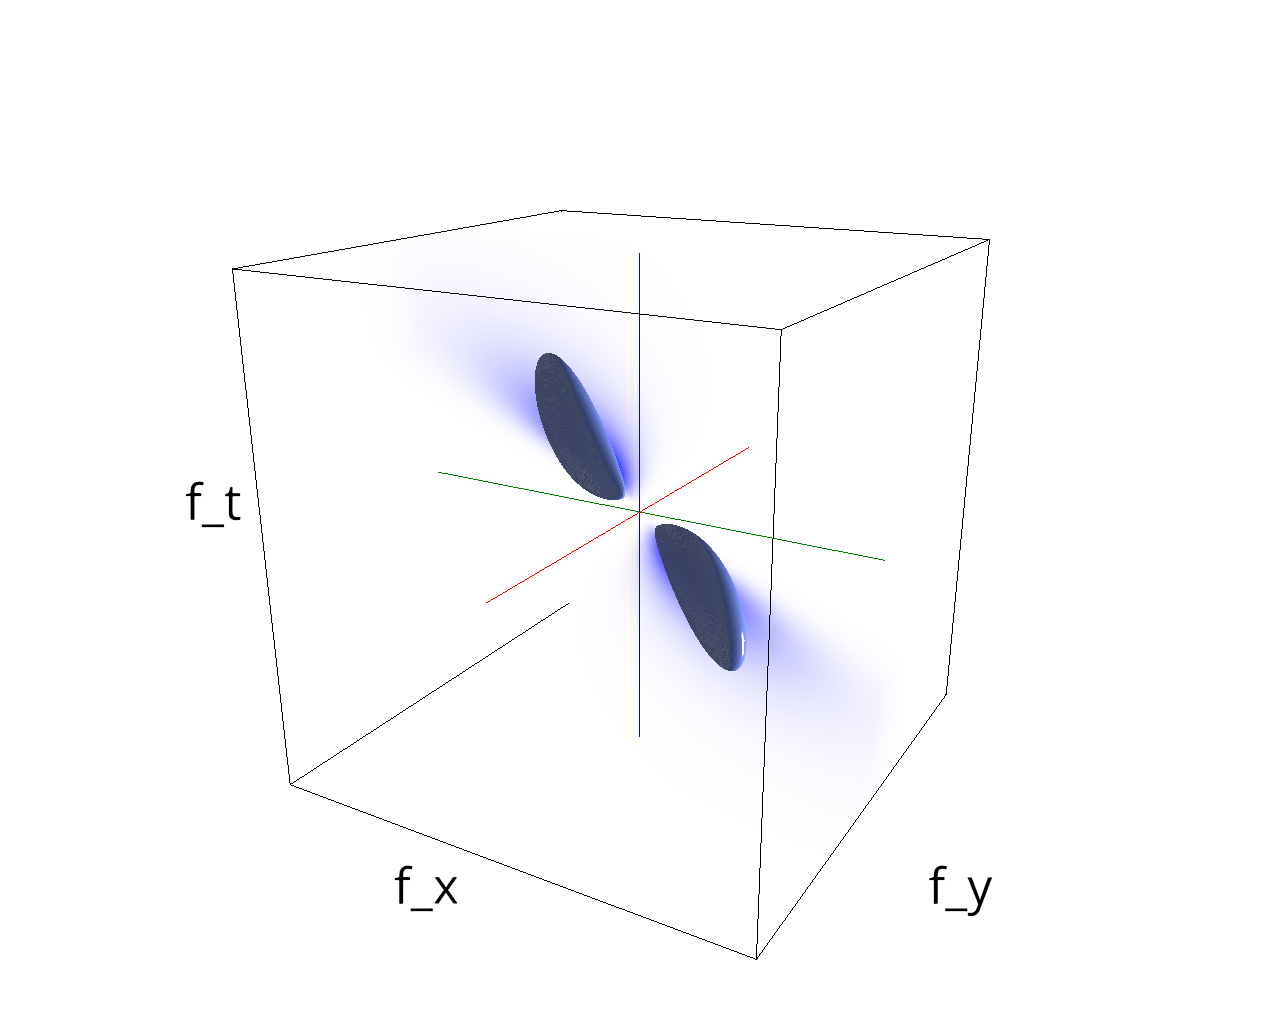

In [10]:
from vispy import app, scene
from vispy.util.transforms import perspective, translate, rotate

canvas = scene.SceneCanvas(keys='interactive', size =(1280, 1024), position = (0, 0), bgcolor='white', dpi=450)

view = canvas.central_widget.add_view()

volume = scene.visuals.Volume(z/z.max(), parent=view.scene, emulate_texture=True)
center = scene.transforms.STTransform(translate=(-mc.N_X/2, -mc.N_Y/2, -mc.N_frame/2))
volume.transform = center
volume.cmap = 'blues'

surface = scene.visuals.Isosurface(z, level=z.max()/4.,
                                   color=(0.5, 0.6, 1, .9), shading='smooth',
                                   parent=view.scene)
surface.transform = center

t = {}
for text in ['f_x', 'f_y', 'f_t']:
    t[text] = scene.visuals.Text(text, parent=canvas.scene, color='black')
    t[text].font_size = 8
t['f_x'].pos = canvas.size[0] // 3, canvas.size[1] - canvas.size[1] // 8
t['f_y'].pos = canvas.size[0] - canvas.size[0] // 4, canvas.size[1] - canvas.size[1] // 8
t['f_t'].pos = canvas.size[0] // 6, canvas.size[1] // 2

N_X, N_Y, N_frame= mc.N_X, mc.N_Y, mc.N_frame
for p in ([1, 1, 1, -1, 1, 1], [1, 1, -1, -1, 1, -1], [1, -1, 1, -1, -1, 1],[1, -1, -1, -1, -1, -1], 
          [1, 1, 1, 1, -1, 1], [-1, 1, 1, -1, -1, 1], [1, 1, -1, 1, -1, -1], [-1, 1, -1, -1, -1, -1], 
          [1, 1, 1, 1, 1, -1], [-1, 1, 1, -1, 1, -1], [1, -1, 1, 1, -1, -1], [-1, -1, 1, -1, -1, -1]):
    line = scene.visuals.Line(pos=np.array([[p[0]*N_X/2, p[1]*N_Y/2, p[2]*N_frame/2], [p[3]*N_X/2, p[4]*N_Y/2, p[5]*N_frame/2]]), color='black', parent=view.scene)

axisX = scene.visuals.Line(pos=np.array([[0, -N_Y/2, 0], [0, N_Y/2, 0]]), color='red', parent=view.scene)
axisY = scene.visuals.Line(pos=np.array([[-N_X/2, 0, 0], [N_X/2, 0, 0]]), color='green', parent=view.scene)
axisZ = scene.visuals.Line(pos=np.array([[0, 0, -N_frame/2], [0, 0, N_frame/2]]), color='blue', parent=view.scene)



axis = scene.visuals.XYZAxis(parent=view.scene)
cam = scene.TurntableCamera(elevation=20, azimuth=30)
cam.fov = 45
cam.scale_factor = mc.N_X * 2.
cam.set_range((-mc.N_X/2, mc.N_X/2), (-mc.N_Y/2, mc.N_Y/2), (-mc.N_frame/2, mc.N_frame/2))
view.camera = cam
#view.set_camera('turntable', mode='perspective', up='z', distance=2,
#                azimuth=30., elevation=30.)
# The rendering is done, we get the rendering output (4D NumPy array)
# Use render to generate an image object
im = canvas.render()
im2img(im)

Looks promising! Let's first test the axis are right:

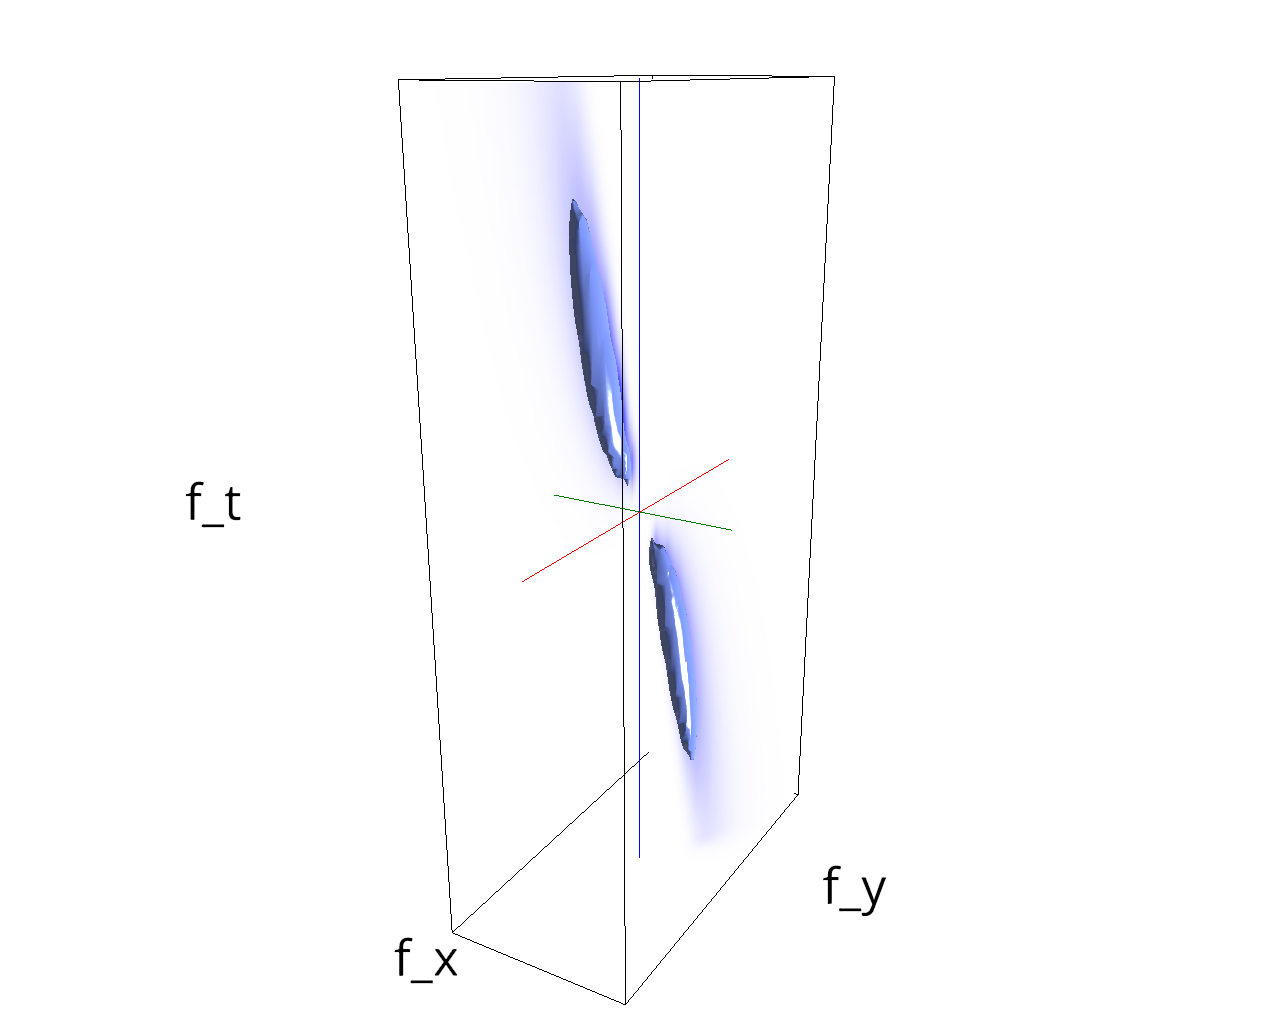

In [11]:
import MotionClouds as mc

figsize = (900, 900)
mc.N_X, mc.N_Y, mc.N_frame = 2**5, 2**6, 2**7
N_X, N_Y, N_frame = mc.N_X, mc.N_Y, mc.N_frame
fx, fy, ft = mc.get_grids(mc.N_X, mc.N_Y, mc.N_frame)
z =  mc.envelope_gabor(fx, fy, ft, V_X=1., V_Y=1., theta=np.pi/4)

import numpy as np
from vispy import app, scene
from vispy.util.transforms import perspective, translate, rotate

canvas = scene.SceneCanvas(keys='interactive', size =(1280, 1024), position = (0, 0), bgcolor='white', dpi=450)

view = canvas.central_widget.add_view()


vol_data = np.rollaxis(np.rollaxis(z, 1), 2)
volume = scene.visuals.Volume(vol_data, parent=view.scene)
center = scene.transforms.STTransform(translate=( -N_X/2, -N_Y/2, -N_frame/2))
volume.transform = center
volume.cmap = 'blues'

surface = scene.visuals.Isosurface(z, level=z.max()/4.,
                                   color=(0.5, 0.6, 1, .9), shading='smooth',
                                   parent=view.scene)
surface.transform = center

t = {}
for text in ['f_x', 'f_y', 'f_t']:
    t[text] = scene.visuals.Text(text, parent=canvas.scene, color='black')
    t[text].font_size = 8
t['f_x'].pos = canvas.size[0] // 3, canvas.size[1] - canvas.size[1] // 18
t['f_y'].pos = canvas.size[0] - canvas.size[0] // 3, canvas.size[1] - canvas.size[1] // 8
t['f_t'].pos = canvas.size[0] // 6, canvas.size[1] // 2

N_X, N_Y, N_frame = mc.N_X, mc.N_Y, mc.N_frame
for p in ([1, 1, 1, -1, 1, 1], [1, 1, -1, -1, 1, -1], [1, -1, 1, -1, -1, 1],[1, -1, -1, -1, -1, -1], 
          [1, 1, 1, 1, -1, 1], [-1, 1, 1, -1, -1, 1], [1, 1, -1, 1, -1, -1], [-1, 1, -1, -1, -1, -1], 
          [1, 1, 1, 1, 1, -1], [-1, 1, 1, -1, 1, -1], [1, -1, 1, 1, -1, -1], [-1, -1, 1, -1, -1, -1]):
    line = scene.visuals.Line(pos=np.array([[p[0]*N_X/2, p[1]*N_Y/2, p[2]*N_frame/2], [p[3]*N_X/2, p[4]*N_Y/2, p[5]*N_frame/2]]), color='black', parent=view.scene)

axisX = scene.visuals.Line(pos=np.array([[0, -N_Y/2, 0], [0, N_Y/2, 0]]), color='red', parent=view.scene)
axisY = scene.visuals.Line(pos=np.array([[-N_X/2, 0, 0], [N_X/2, 0, 0]]), color='green', parent=view.scene)
axisZ = scene.visuals.Line(pos=np.array([[0, 0, -N_frame/2], [0, 0, N_frame/2]]), color='blue', parent=view.scene)


axis = scene.visuals.XYZAxis(parent=view.scene)
cam = scene.TurntableCamera(elevation=20, azimuth=30)
cam.fov = 45
cam.scale_factor = mc.N_X * 5.
cam.set_range((-mc.N_X/2, mc.N_X/2), (-mc.N_Y/2, mc.N_Y/2), (-mc.N_frame/2, mc.N_frame/2))
view.camera = cam
#view.set_camera('turntable', mode='perspective', up='z', distance=2,
#                azimuth=30., elevation=30.)
# The rendering is done, we get the rendering output (4D NumPy array)
# Use render to generate an image object
im = canvas.render()
im2img(im)

Drawing more than one isosurface:

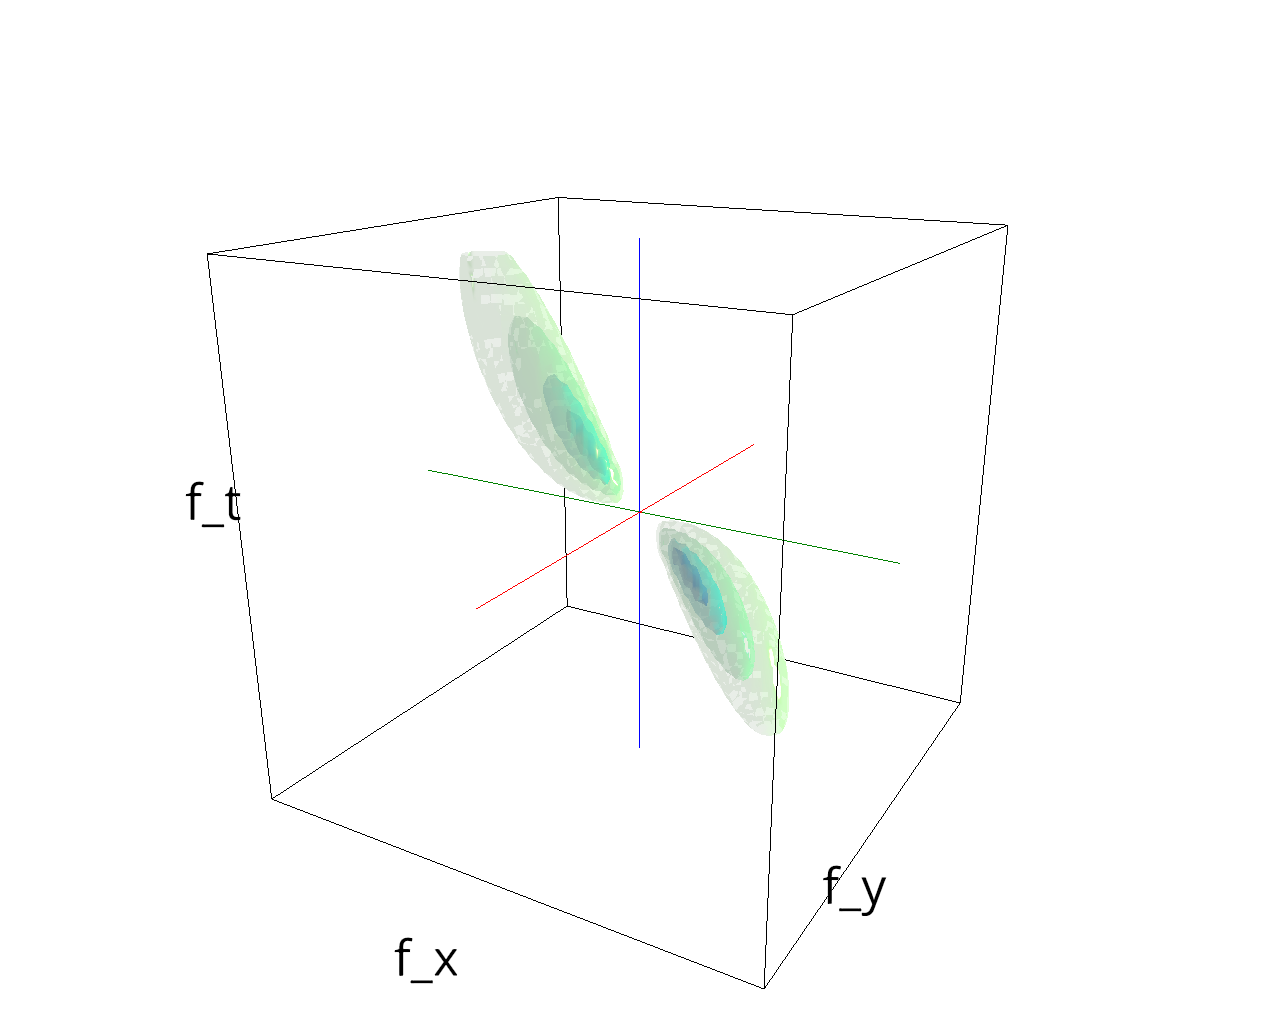

In [12]:
import MotionClouds as mc
figsize = (900, 900)
mc.N_X, mc.N_Y, mc.N_frame = 2**6, 2**6, 2**6
N_X, N_Y, N_frame = mc.N_X, mc.N_Y, mc.N_frame
fx, fy, ft = mc.get_grids(mc.N_X, mc.N_Y, mc.N_frame)
z =  mc.envelope_gabor(fx, fy, ft, V_X=1., V_Y=1., theta=np.pi/4)

z /= z.max()

import numpy as np
from vispy import app, scene
from vispy.util.transforms import perspective, translate, rotate
thresholds=[0.94, .89, .75, .5, .25, .1]
opacities=[.9, .8, .7, .5, .2, .1]

from vispy.color import Color
import colorsys
canvas = scene.SceneCanvas(keys='interactive', size =(1280, 1024), position = (0, 0), bgcolor='white', dpi=450)

view = canvas.central_widget.add_view()


vol_data = np.rollaxis(np.rollaxis(z, 1), 2)
#volume = scene.visuals.Volume(vol_data, parent=view.scene)
center = scene.transforms.STTransform(translate=( -N_X/2, -N_Y/2, -N_frame/2))
#volume.transform = center
#volume.cmap = 'blues'

surfaces = []
for threshold, opacity in zip(thresholds, opacities):
    surfaces.append(scene.visuals.Isosurface(z, level=threshold, 
                                color=Color(np.array(colorsys.hsv_to_rgb(.25+threshold/2., 1., 1.)), alpha=opacity),
                                shading='smooth', parent=view.scene)
                                            )
    surfaces[-1].transform = center

t = {}
for text in ['f_x', 'f_y', 'f_t']:
    t[text] = scene.visuals.Text(text, parent=canvas.scene, color='black')
    t[text].font_size = 8
t['f_x'].pos = canvas.size[0] // 3, canvas.size[1] - canvas.size[1] // 18
t['f_y'].pos = canvas.size[0] - canvas.size[0] // 3, canvas.size[1] - canvas.size[1] // 8
t['f_t'].pos = canvas.size[0] // 6, canvas.size[1] // 2

N_X, N_Y, N_frame = mc.N_X, mc.N_Y, mc.N_frame
for p in ([1, 1, 1, -1, 1, 1], [1, 1, -1, -1, 1, -1], [1, -1, 1, -1, -1, 1],[1, -1, -1, -1, -1, -1], 
          [1, 1, 1, 1, -1, 1], [-1, 1, 1, -1, -1, 1], [1, 1, -1, 1, -1, -1], [-1, 1, -1, -1, -1, -1], 
          [1, 1, 1, 1, 1, -1], [-1, 1, 1, -1, 1, -1], [1, -1, 1, 1, -1, -1], [-1, -1, 1, -1, -1, -1]):
    line = scene.visuals.Line(pos=np.array([[p[0]*N_X/2, p[1]*N_Y/2, p[2]*N_frame/2], [p[3]*N_X/2, p[4]*N_Y/2, p[5]*N_frame/2]]), color='black', parent=view.scene)

axisX = scene.visuals.Line(pos=np.array([[0, -N_Y/2, 0], [0, N_Y/2, 0]]), color='red', parent=view.scene)
axisY = scene.visuals.Line(pos=np.array([[-N_X/2, 0,
                                          0], [N_X/2, 0, 0]]), color='green', parent=view.scene)
axisZ = scene.visuals.Line(pos=np.array([[0, 0, -N_frame/2], [0, 0, N_frame/2]]), color='blue', parent=view.scene)

axis = scene.visuals.XYZAxis(parent=view.scene)
cam = scene.TurntableCamera(elevation=20, azimuth=30)
cam.fov = 45
cam.scale_factor = mc.N_X * 1.9
cam.set_range((-mc.N_X/2, mc.N_X/2), (-mc.N_Y/2, mc.N_Y/2), (-mc.N_frame/2, mc.N_frame/2))
view.camera = cam
#view.set_camera('turntable', mode='perspective', up='z', distance=2,
#                azimuth=30., elevation=30.)
# The rendering is done, we get the rendering output (4D NumPy array)
# Use render to generate an image object
im = canvas.render()
im2img(im)

Trying out to add some isocurves:

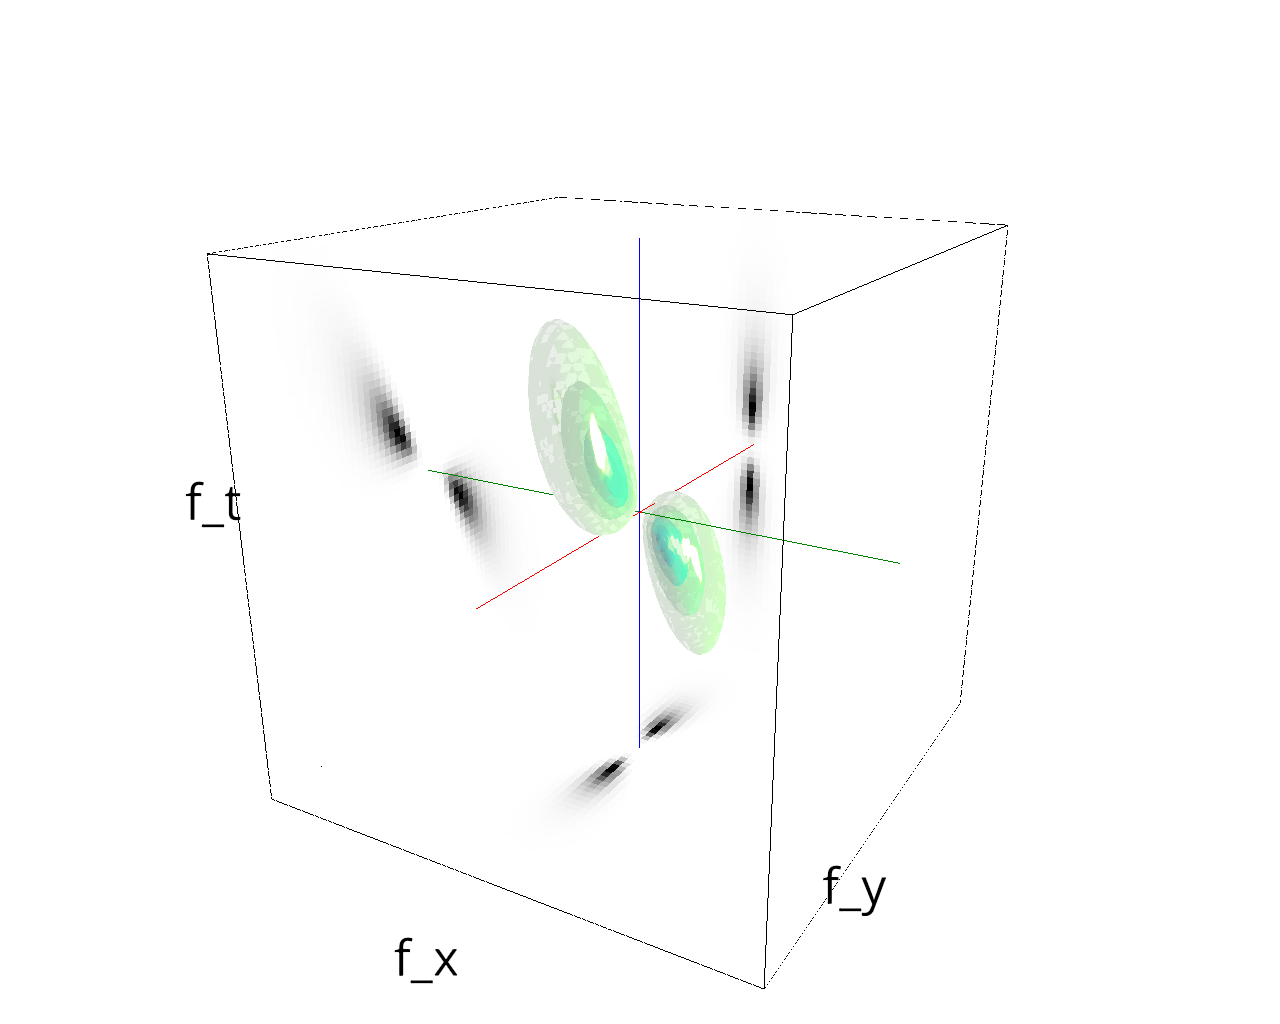

In [13]:
canvas = scene.SceneCanvas(keys='interactive', size =(1280, 1024), position = (0, 0), bgcolor='white', dpi=450)
view = canvas.central_widget.add_view()

z =  mc.envelope_gabor(fx, fy, ft, V_X=0, V_Y=1., theta=np.pi/2)
z /= z.max()

vol_data = np.rollaxis(np.rollaxis(z, 1), 2)
center = scene.transforms.STTransform(translate=( -N_X/2, -N_Y/2, -N_frame/2))

surfaces, curves = [], []
for threshold, opacity in zip(thresholds, opacities):
    surfaces.append(scene.visuals.Isosurface(z, level=threshold, 
                                color=Color(np.array(colorsys.hsv_to_rgb(.25+threshold/2., 1., 1.)), alpha=opacity),
                                shading='smooth', parent=view.scene)
                                            )
    surfaces[-1].transform = center

    
# Create isocurve, make a child of the image to ensure the two are always
# aligned.

# Create the image
from vispy.color import Colormap
cm = Colormap([(1.0, 1.0, 1.0, 0.0), (.0, .0, .0, 1.0)])
opts = {'parent':view.scene, 'cmap':cm, 'clim':(0., 1.)}
energy_xy = np.rot90(np.max(z, axis=2)[:, ::-1], 3)#
fourier_xy = scene.visuals.Image(np.rot90(energy_xy), **opts)#, parent=view.scene, cmap='grays', clim=(1.-energy_xy.max(), 1))
#image_xy = scene.visuals.Image(np.rot90(im_mc[:, :, 0], 3), **opts)
tr_xy = scene.transforms.MatrixTransform()
tr_xy.rotate(90, (0, 0, 1))
tr_xy.translate((mc.N_X/2, -mc.N_Y/2, -mc.N_frame/2))
fourier_xy.transform = tr_xy

#image_xt = scene.visuals.Image(np.rot90(im_mc[:, -1, :], 3), **opts)
energy_xt = np.rot90(np.max(z, axis=1)[:, ::-1], 3)
fourier_xt = scene.visuals.Image(energy_xt, **opts)#, parent=view.scene, cmap='grays', clim=(1.-energy_xt.max(), 1.))
tr_xt = scene.transforms.MatrixTransform()
tr_xt.rotate(90, (1, 0, 0))
tr_xt.translate((-mc.N_X/2, mc.N_Y/2, -mc.N_frame/2))
fourier_xt.transform = tr_xt

#image_yt = scene.visuals.Image(np.rot90(im_mc[-1, :, :], 3), **opts)
energy_yt = np.max(z, axis=0)[:, ::-1]
fourier_yt = scene.visuals.Image(energy_yt, **opts)#, parent=view.scene, cmap='grays', clim=(1.- energy_yt.max(), 1.))
tr_yt = scene.transforms.MatrixTransform()
tr_yt.rotate(90, (0, 1, 0))
tr_yt.translate((-mc.N_X/2, -mc.N_Y/2, mc.N_frame/2))
fourier_yt.transform = tr_yt


t = {}
for text in ['f_x', 'f_y', 'f_t']:
    t[text] = scene.visuals.Text(text, parent=canvas.scene, color='black')
    t[text].font_size = 8
t['f_x'].pos = canvas.size[0] // 3, canvas.size[1] - canvas.size[1] // 18
t['f_y'].pos = canvas.size[0] - canvas.size[0] // 3, canvas.size[1] - canvas.size[1] // 8
t['f_t'].pos = canvas.size[0] // 6, canvas.size[1] // 2

N_X, N_Y, N_frame = mc.N_X, mc.N_Y, mc.N_frame
for p in ([1, 1, 1, -1, 1, 1], [1, 1, -1, -1, 1, -1], [1, -1, 1, -1, -1, 1],[1, -1, -1, -1, -1, -1], 
          [1, 1, 1, 1, -1, 1], [-1, 1, 1, -1, -1, 1], [1, 1, -1, 1, -1, -1], [-1, 1, -1, -1, -1, -1], 
          [1, 1, 1, 1, 1, -1], [-1, 1, 1, -1, 1, -1], [1, -1, 1, 1, -1, -1], [-1, -1, 1, -1, -1, -1]):
    line = scene.visuals.Line(pos=np.array([[p[0]*N_X/2, p[1]*N_Y/2, p[2]*N_frame/2], [p[3]*N_X/2, p[4]*N_Y/2, p[5]*N_frame/2]]), color='black', parent=view.scene)

axisX = scene.visuals.Line(pos=np.array([[0, -N_Y/2, 0], [0, N_Y/2, 0]]), color='red', parent=view.scene)
axisY = scene.visuals.Line(pos=np.array([[-N_X/2, 0, 0], [N_X/2, 0, 0]]), color='green', parent=view.scene)
axisZ = scene.visuals.Line(pos=np.array([[0, 0, -N_frame/2], [0, 0, N_frame/2]]), color='blue', parent=view.scene)

axis = scene.visuals.XYZAxis(parent=view.scene)
cam = scene.TurntableCamera(elevation=20, azimuth=30)
cam.fov = 45
cam.scale_factor = mc.N_X * 1.9
cam.set_range((-mc.N_X/2, mc.N_X/2), (-mc.N_Y/2, mc.N_Y/2), (-mc.N_frame/2, mc.N_frame/2))
view.camera = cam
#view.set_camera('turntable', mode='perspective', up='z', distance=2,
#                azimuth=30., elevation=30.)
# The rendering is done, we get the rendering output (4D NumPy array)
# Use render to generate an image object
im = canvas.render()
im2img(im)

For the textured cube, we may also use http://api.vispy.org/en/latest/examples/tutorial/gloo/textured_cube.html?highlight=create_cube

In [14]:
%%writefile /tmp/cube_mc.py
# -*- coding: utf-8 -*-
# -----------------------------------------------------------------------------
# Copyright (c) 2014, Vispy Development Team. All Rights Reserved.
# Distributed under the (new) BSD License. See LICENSE.txt for more info.
# -----------------------------------------------------------------------------
# Author: Nicolas P .Rougier
# Date:   04/03/2014
# -----------------------------------------------------------------------------
import numpy as np

from vispy import gloo, app
from vispy.gloo import Program, VertexBuffer, IndexBuffer
from vispy.util.transforms import perspective, translate, rotate
from vispy.geometry import create_cube


vertex = """
uniform mat4 model;
uniform mat4 view;
uniform mat4 projection;
uniform sampler2D texture;

attribute vec3 position;
attribute vec2 texcoord;
attribute vec3 normal;
attribute vec4 color;

varying vec2 v_texcoord;
void main()
{
    gl_Position = projection * view * model * vec4(position,1.0);
    v_texcoord = texcoord;
}
"""

fragment = """
uniform sampler2D texture;
varying vec2 v_texcoord;
void main()
{
    gl_FragColor = texture2D(texture, v_texcoord);
}
"""


class Canvas(app.Canvas):
    def __init__(self):
        app.Canvas.__init__(self, size=(512, 512), title='Textured cube',
                            keys='interactive')
        self.timer = app.Timer('auto', self.on_timer)

        # Build cube data
        V, I, _ = create_cube()
        vertices = VertexBuffer(V)
        self.indices = IndexBuffer(I)

        # Build program
        self.program = Program(vertex, fragment)
        self.program.bind(vertices)

        # Build view, model, projection & normal
        view = translate((0, 0, -5))
        model = np.eye(4, dtype=np.float32)
        self.program['model'] = model
        self.program['view'] = view
        self.program['texture'] = (255 * im_mc[:, :, 0]).astype(np.uint8)

        self.activate_zoom()

        self.phi, self.theta = 0, 0

        # OpenGL initalization
        gloo.set_state(clear_color=(0.30, 0.30, 0.35, 1.00), depth_test=True)
        self.timer.start()

        self.show()

    def on_draw(self, event):
        gloo.clear(color=True, depth=True)
        self.program.draw('triangles', self.indices)

    def on_resize(self, event):
        self.activate_zoom()

    def activate_zoom(self):
        gloo.set_viewport(0, 0, *self.physical_size)
        projection = perspective(45.0, self.size[0] / float(self.size[1]),
                                 2.0, 10.0)
        self.program['projection'] = projection

    def on_timer(self, event):
        self.theta += .5
        self.phi += .5
        self.program['model'] = np.dot(rotate(self.theta, (0, 0, 1)),
                                       rotate(self.phi, (0, 1, 0)))
        self.update()

if __name__ == '__main__':
    c = Canvas()
    app.run()


Overwriting /tmp/cube_mc.py


Let's create an empty cube with some axis:

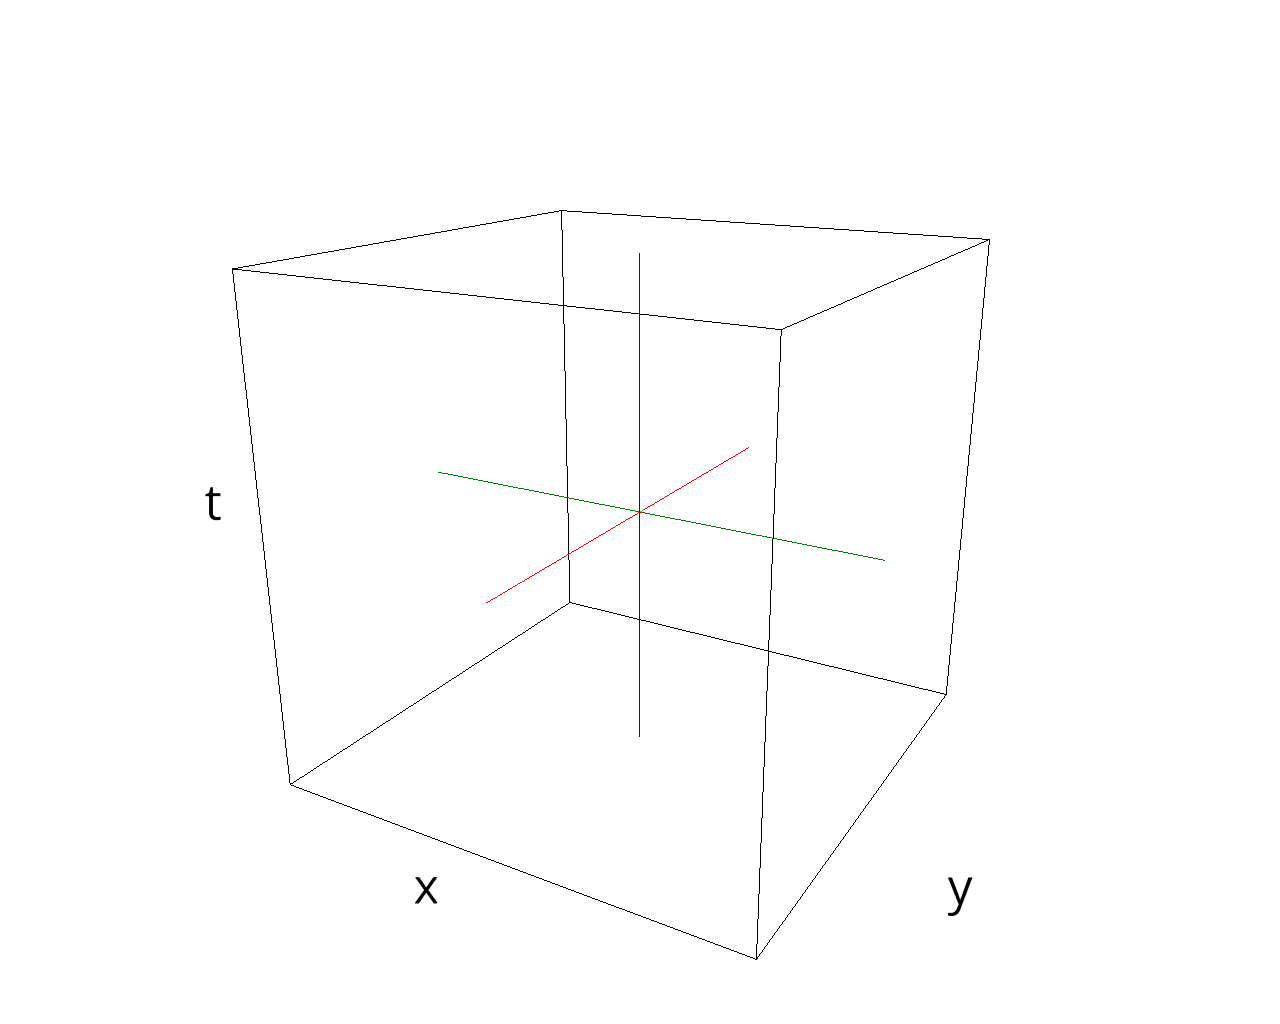

In [15]:
from vispy import app, scene
from vispy.util.transforms import perspective, translate, rotate

canvas = scene.SceneCanvas(keys='interactive', size =(1280, 1024), position = (0, 0), bgcolor='white', dpi=450)

view = canvas.central_widget.add_view()

N_X, N_Y, N_frame = mc.N_X, mc.N_Y, mc.N_frame
for p in ([1, 1, 1, -1, 1, 1], [1, 1, -1, -1, 1, -1], [1, -1, 1, -1, -1, 1],[1, -1, -1, -1, -1, -1], 
          [1, 1, 1, 1, -1, 1], [-1, 1, 1, -1, -1, 1], [1, 1, -1, 1, -1, -1], [-1, 1, -1, -1, -1, -1], 
          [1, 1, 1, 1, 1, -1], [-1, 1, 1, -1, 1, -1], [1, -1, 1, 1, -1, -1], [-1, -1, 1, -1, -1, -1]):
    line = scene.visuals.Line(pos=np.array([[p[0]*N_X/2, p[1]*N_Y/2, p[2]*N_frame/2], [p[3]*N_X/2, p[4]*N_Y/2, p[5]*N_frame/2]]), color='black', parent=view.scene)

axisX = scene.visuals.Line(pos=np.array([[0, -N_Y/2, 0], [0, N_Y/2, 0]]), color='red', parent=view.scene)
axisY = scene.visuals.Line(pos=np.array([[-N_X/2, 0, 0], [N_X/2, 0, 0]]), color='green', parent=view.scene)
axisZ = scene.visuals.Line(pos=np.array([[0, 0, -N_frame/2], [0, 0, N_frame/2]]), color='blue', parent=view.scene)

t = {}
for text in ['x', 'y', 't']:
    t[text] = scene.visuals.Text(text, parent=canvas.scene, color='black')
    t[text].font_size = 8
t['x'].pos = canvas.size[0] // 3, canvas.size[1] - canvas.size[1] // 8
t['y'].pos = canvas.size[0] - canvas.size[0] // 4, canvas.size[1] - canvas.size[1] // 8
t['t'].pos = canvas.size[0] // 6, canvas.size[1] // 2

axis = scene.visuals.XYZAxis(parent=view.scene)
cam = scene.TurntableCamera(elevation=20, azimuth=30)
cam.fov = 45
cam.scale_factor = mc.N_X * 2.
cam.set_range((-mc.N_X/2, mc.N_X/2), (-mc.N_Y/2, mc.N_Y/2), (-mc.N_frame/2, mc.N_frame/2))
view.camera = cam
im = canvas.render()
im2img(im)

We will try to map the following images on the faces of the cube:

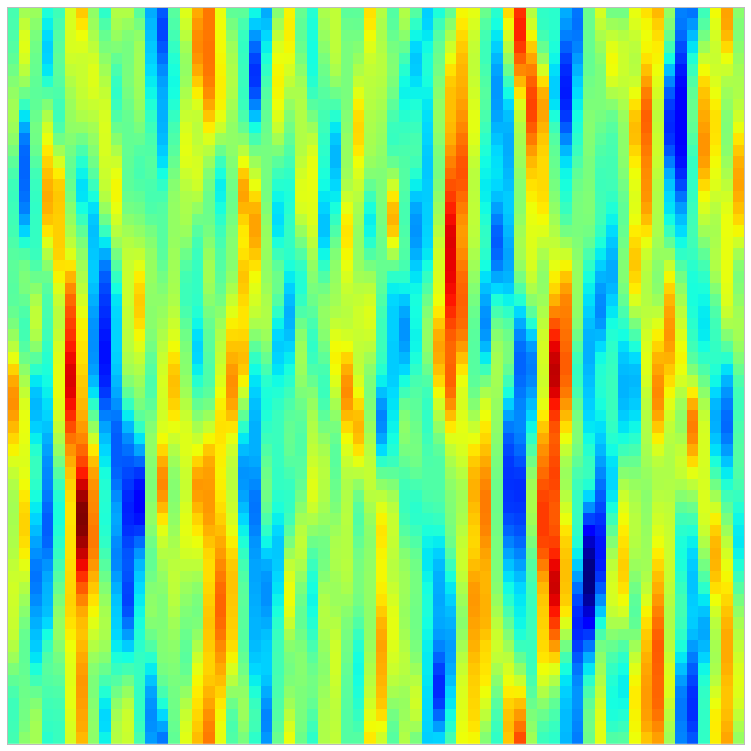

In [16]:
import MotionClouds as mc
fx, fy, ft = mc.get_grids(mc.N_X, mc.N_Y, mc.N_frame)
color = mc.envelope_color(fx, fy, ft) #

z = color * mc.envelope_gabor(fx, fy, ft)
im_mc =  mc.rectif(mc.random_cloud(z))

im2plt(im_mc[:, :, 0].T)

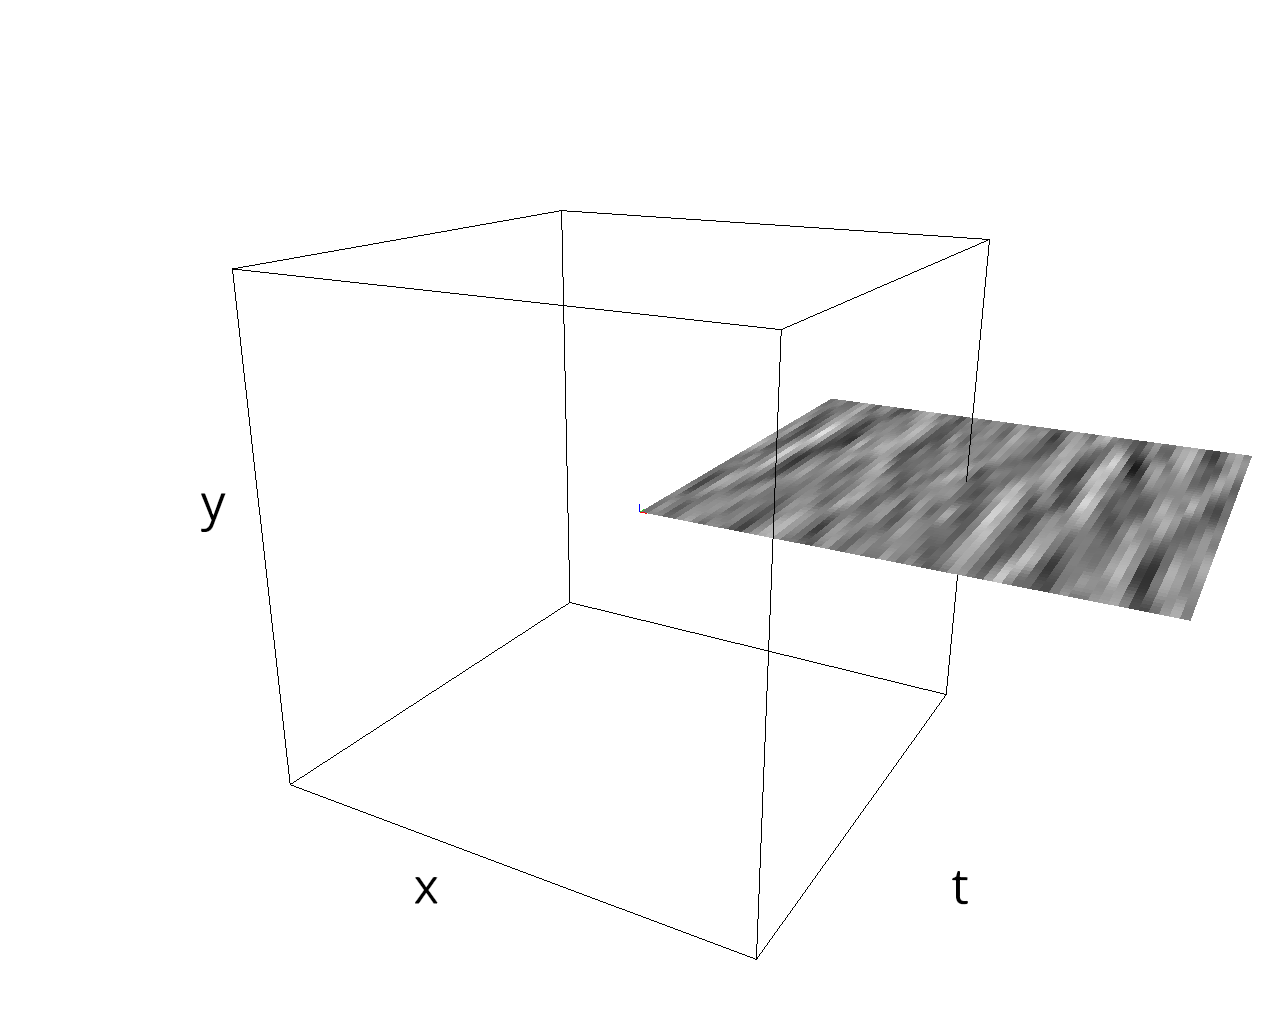

In [17]:
import numpy as np
from vispy import app, scene
from vispy.util.transforms import perspective, translate, rotate

canvas = scene.SceneCanvas(keys='interactive', size =(1280, 1024), position = (0, 0), bgcolor='white', dpi=450)
view = canvas.central_widget.add_view()

N_X, N_Y, N_frame = mc.N_X, mc.N_Y, mc.N_frame
for p in ([1, 1, 1, -1, 1, 1], [1, 1, -1, -1, 1, -1], [1, -1, 1, -1, -1, 1],[1, -1, -1, -1, -1, -1], 
          [1, 1, 1, 1, -1, 1], [-1, 1, 1, -1, -1, 1], [1, 1, -1, 1, -1, -1], [-1, 1, -1, -1, -1, -1], 
          [1, 1, 1, 1, 1, -1], [-1, 1, 1, -1, 1, -1], [1, -1, 1, 1, -1, -1], [-1, -1, 1, -1, -1, -1]):
    line = scene.visuals.Line(pos=np.array([[p[0]*N_X/2, p[1]*N_Y/2, p[2]*N_frame/2], [p[3]*N_X/2, p[4]*N_Y/2, p[5]*N_frame/2]]), color='black', parent=view.scene)

# Create the image
image_xy = scene.visuals.Image(im_mc[:, :, 0].T, parent=view.scene, cmap='grays', clim=(0., 1.))

t = {}
for text in ['x', 'y', 't']:
    t[text] = scene.visuals.Text(text, parent=canvas.scene, color='black')
    t[text].font_size = 8
t['x'].pos = canvas.size[0] // 3, canvas.size[1] - canvas.size[1] // 8
t['t'].pos = canvas.size[0] - canvas.size[0] // 4, canvas.size[1] - canvas.size[1] // 8
t['y'].pos = canvas.size[0] // 6, canvas.size[1] // 2

axis = scene.visuals.XYZAxis(parent=view.scene)
cam = scene.TurntableCamera(elevation=20, azimuth=30)
cam.fov = 45
cam.scale_factor = mc.N_X * 2.
cam.set_range((-mc.N_X/2, mc.N_X/2), (-mc.N_Y/2, mc.N_Y/2), (-mc.N_frame/2, mc.N_frame/2))
view.camera = cam

im2img(canvas.render())

Let's now rotate and translete this object:

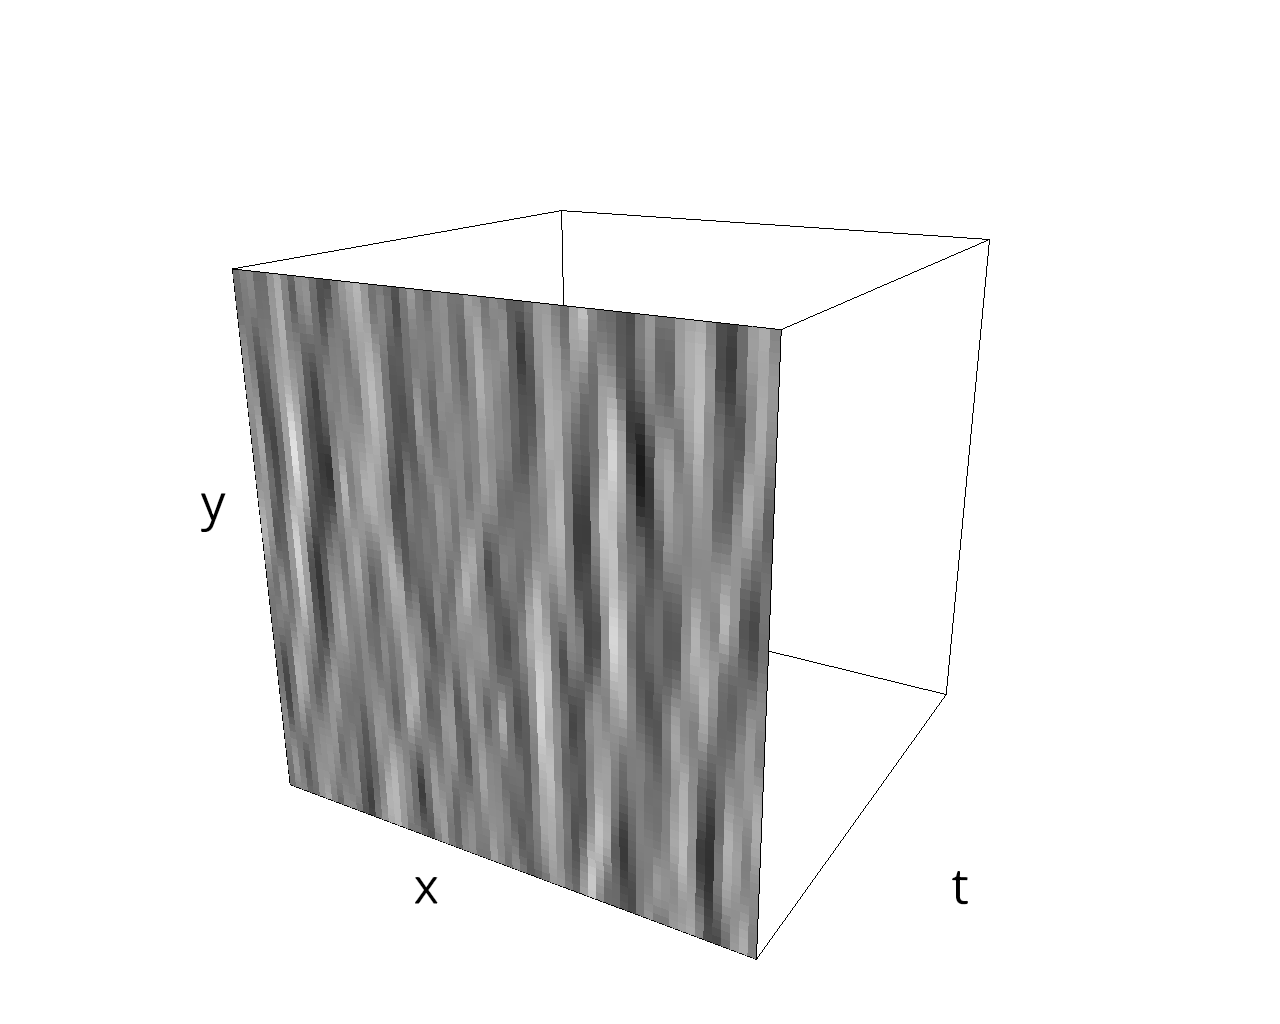

In [18]:
import numpy as np
from vispy import app, scene
from vispy.util.transforms import perspective, translate, rotate

canvas = scene.SceneCanvas(keys='interactive', size =(1280, 1024), position = (0, 0), bgcolor='white', dpi=450)
view = canvas.central_widget.add_view()

N_X, N_Y, N_frame = mc.N_X, mc.N_Y, mc.N_frame
for p in ([1, 1, 1, -1, 1, 1], [1, 1, -1, -1, 1, -1], [1, -1, 1, -1, -1, 1],[1, -1, -1, -1, -1, -1], 
          [1, 1, 1, 1, -1, 1], [-1, 1, 1, -1, -1, 1], [1, 1, -1, 1, -1, -1], [-1, 1, -1, -1, -1, -1], 
          [1, 1, 1, 1, 1, -1], [-1, 1, 1, -1, 1, -1], [1, -1, 1, 1, -1, -1], [-1, -1, 1, -1, -1, -1]):
    line = scene.visuals.Line(pos=np.array([[p[0]*N_X/2, p[1]*N_Y/2, p[2]*N_frame/2], [p[3]*N_X/2, p[4]*N_Y/2, p[5]*N_frame/2]]), color='black', parent=view.scene)

# Create the image
image_xy = scene.visuals.Image(im_mc[:, :, 0].T, parent=view.scene, cmap='grays', clim=(0., 1.))
tr_xy = scene.transforms.MatrixTransform()
tr_xy.rotate(90, (1, 0, 0))
tr_xy.translate((-mc.N_X/2, -mc.N_Y/2, -mc.N_frame/2))
image_xy.transform = tr_xy

t = {}
for text in ['x', 'y', 't']:
    t[text] = scene.visuals.Text(text, parent=canvas.scene, color='black')
    t[text].font_size = 8
t['x'].pos = canvas.size[0] // 3, canvas.size[1] - canvas.size[1] // 8
t['t'].pos = canvas.size[0] - canvas.size[0] // 4, canvas.size[1] - canvas.size[1] // 8
t['y'].pos = canvas.size[0] // 6, canvas.size[1] // 2

axis = scene.visuals.XYZAxis(parent=view.scene)
cam = scene.TurntableCamera(elevation=20, azimuth=30)
cam.fov = 45
cam.scale_factor = mc.N_X * 2.
cam.set_range((-mc.N_X/2, mc.N_X/2), (-mc.N_Y/2, mc.N_Y/2), (-mc.N_frame/2, mc.N_frame/2))
view.camera = cam

im2img(canvas.render())

Let's do the same with the other faces:

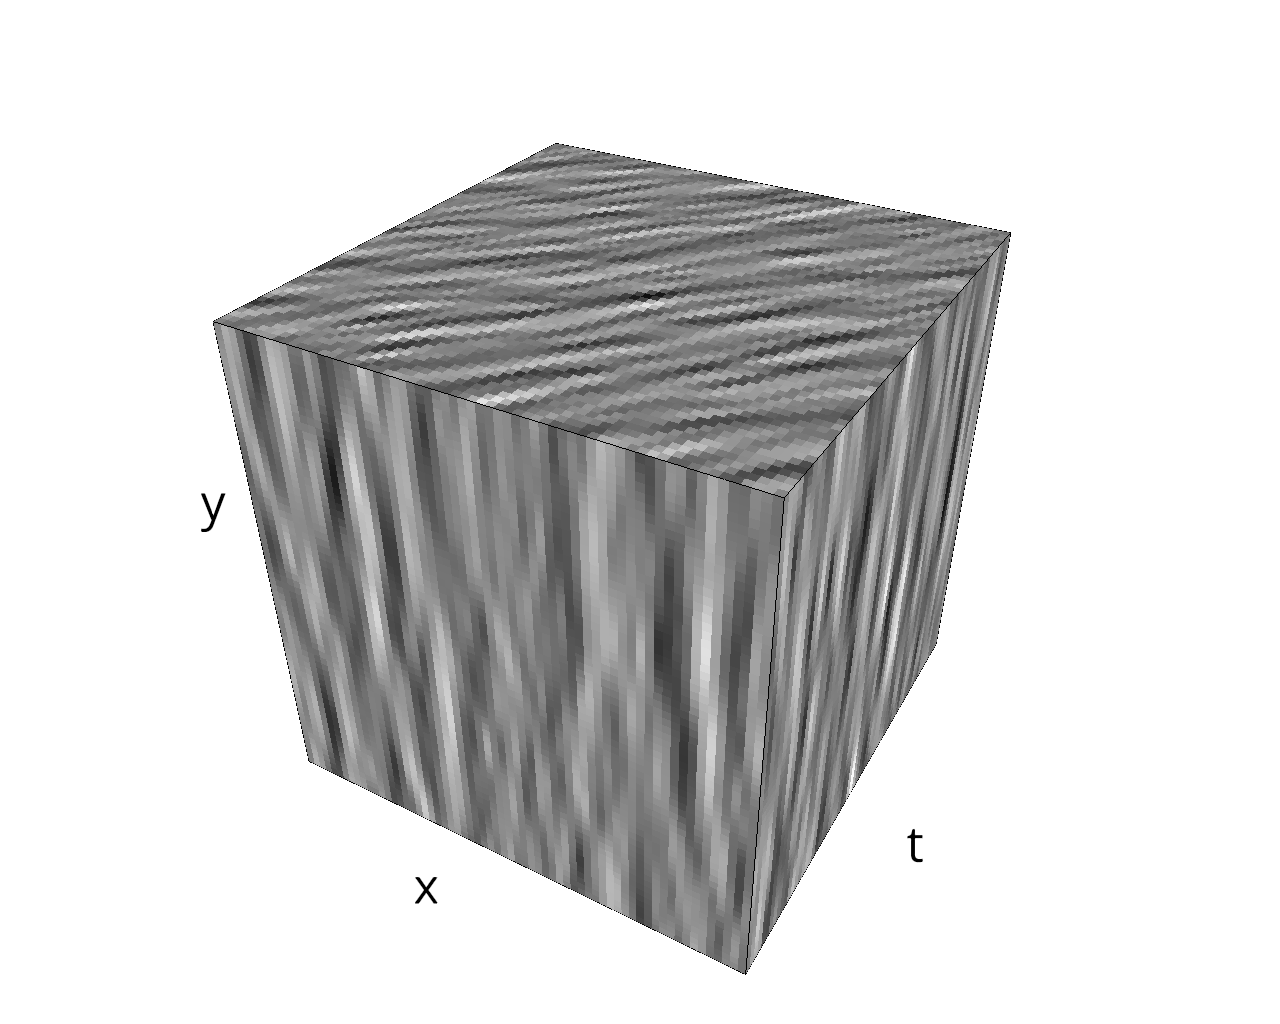

In [19]:
import numpy as np
from vispy import app, scene
from vispy.util.transforms import perspective, translate, rotate

canvas = scene.SceneCanvas(keys='interactive', size =(1280, 1024), position = (0, 0), bgcolor='white', dpi=450)
view = canvas.central_widget.add_view()

N_X, N_Y, N_frame = mc.N_X, mc.N_Y, mc.N_frame
for p in ([1, 1, 1, -1, 1, 1], [1, 1, -1, -1, 1, -1], [1, -1, 1, -1, -1, 1],[1, -1, -1, -1, -1, -1], 
          [1, 1, 1, 1, -1, 1], [-1, 1, 1, -1, -1, 1], [1, 1, -1, 1, -1, -1], [-1, 1, -1, -1, -1, -1], 
          [1, 1, 1, 1, 1, -1], [-1, 1, 1, -1, 1, -1], [1, -1, 1, 1, -1, -1], [-1, -1, 1, -1, -1, -1]):
    line = scene.visuals.Line(pos=np.array([[p[0]*N_X/2, p[1]*N_Y/2, p[2]*N_frame/2], [p[3]*N_X/2, p[4]*N_Y/2, p[5]*N_frame/2]]), color='black', parent=view.scene)

# Create the image
opts = {'parent':view.scene, 'cmap':'grays', 'clim':(0., 1.)}
image_xy = scene.visuals.Image(np.rot90(im_mc[:, :, 0], 3), **opts)
tr_xy = scene.transforms.MatrixTransform()
tr_xy.rotate(90, (1, 0, 0))
tr_xy.translate((-mc.N_X/2, -mc.N_Y/2, -mc.N_frame/2))
image_xy.transform = tr_xy

image_xt = scene.visuals.Image(np.rot90(im_mc[:, -1, :], 3), **opts)
tr_xt = scene.transforms.MatrixTransform()
tr_xt.rotate(90, (0, 0, 1))
tr_xt.translate((mc.N_X/2, -mc.N_Y/2, mc.N_frame/2))
image_xt.transform = tr_xt

image_yt = scene.visuals.Image(np.rot90(im_mc[-1, :, :], 3), **opts)
tr_yt = scene.transforms.MatrixTransform()
tr_yt.rotate(90, (0, 1, 0))
tr_yt.translate((mc.N_X/2, -mc.N_Y/2, mc.N_frame/2))
image_yt.transform = tr_yt

t = {}
for text in ['x', 'y', 't']:
    t[text] = scene.visuals.Text(text, parent=canvas.scene, color='black')
    t[text].font_size = 8
t['x'].pos = canvas.size[0] // 3, canvas.size[1] - canvas.size[1] // 8
t['t'].pos = canvas.size[0] - canvas.size[0] // 3.5, canvas.size[1] - canvas.size[1] // 6
t['y'].pos = canvas.size[0] // 6, canvas.size[1] // 2

axis = scene.visuals.XYZAxis(parent=view.scene)
cam = scene.TurntableCamera(elevation=35, azimuth=30)
cam.fov = 45
cam.scale_factor = mc.N_X * 2.
cam.set_range((-mc.N_X/2, mc.N_X/2), (-mc.N_Y/2, mc.N_Y/2), (-mc.N_frame/2, mc.N_frame/2))
view.camera = cam

im2img(canvas.render())

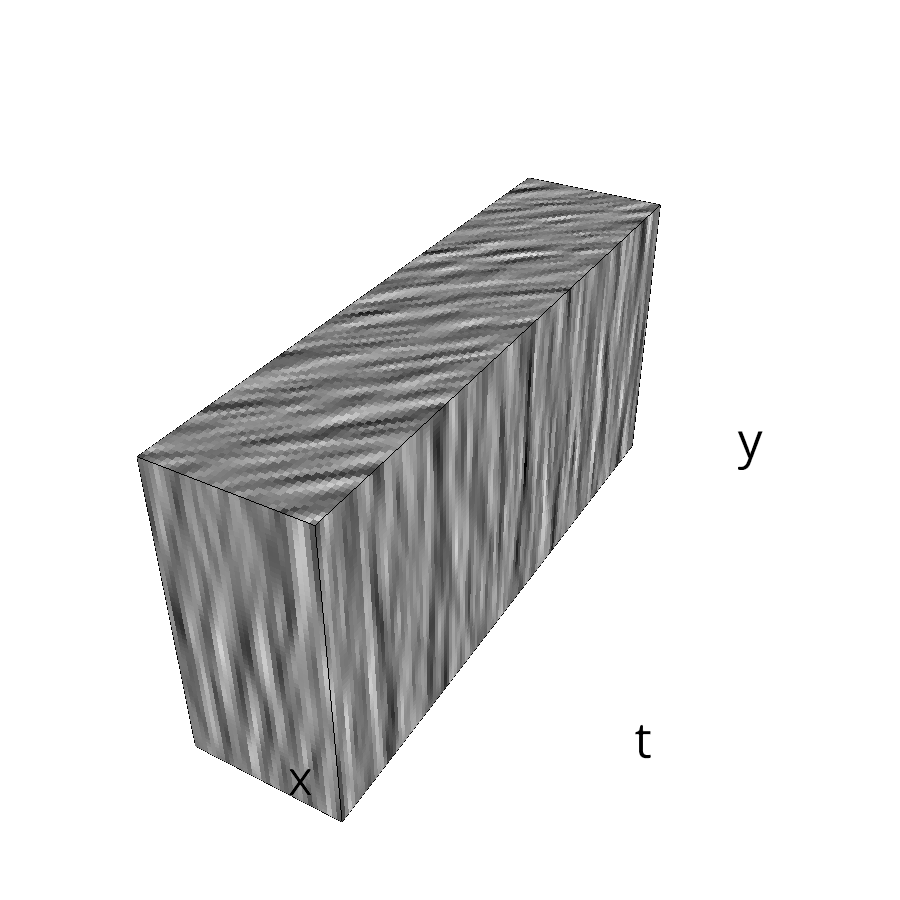

In [20]:
import MotionClouds as mc

figsize = (900, 900)  # faster
mc.N_X, mc.N_Y, mc.N_frame = 2**5, 2**6, 2**7
N_X, N_Y, N_frame = mc.N_X, mc.N_Y, mc.N_frame
fx, fy, ft = mc.get_grids(mc.N_X, mc.N_Y, mc.N_frame)
z =  mc.envelope_gabor(fx, fy, ft)
im =  mc.rectif(mc.random_cloud(z))

import numpy as np
from vispy import app, scene
app.use_app('pyglet')
from vispy.util.transforms import perspective, translate, rotate

canvas = scene.SceneCanvas(size=figsize, bgcolor='white', dpi=450)
view = canvas.central_widget.add_view()

N_X, N_Y, N_frame = mc.N_X, mc.N_Y, mc.N_frame
for p in ([1, 1, 1, -1, 1, 1], [1, 1, -1, -1, 1, -1], [1, -1, 1, -1, -1, 1],[1, -1, -1, -1, -1, -1], 
          [1, 1, 1, 1, -1, 1], [-1, 1, 1, -1, -1, 1], [1, 1, -1, 1, -1, -1], [-1, 1, -1, -1, -1, -1], 
          [1, 1, 1, 1, 1, -1], [-1, 1, 1, -1, 1, -1], [1, -1, 1, 1, -1, -1], [-1, -1, 1, -1, -1, -1]):
            line = scene.visuals.Line(pos=np.array([[p[0]*N_X/2, p[1]*N_frame/2, p[2]*N_Y/2], 
                                                    [p[3]*N_X/2, p[4]*N_frame/2, p[5]*N_Y/2]]), color='black', parent=view.scene)


# Create the image
opts = {'parent':view.scene, 'cmap':'grays', 'clim':(0., 1.)}
image_xy = scene.visuals.Image(np.rot90(im[:, :, 0], 3), **opts)
tr_xy = scene.transforms.MatrixTransform()
tr_xy.rotate(90, (1, 0, 0))
tr_xy.translate((-N_X/2, -N_frame/2, -N_Y/2))
image_xy.transform = tr_xy

image_xt = scene.visuals.Image(np.fliplr(im[:, -1, :]), **opts)
tr_xt = scene.transforms.MatrixTransform()
tr_xt.rotate(90, (0, 0, 1))
tr_xt.translate((N_X/2, -N_frame/2, N_Y/2))
image_xt.transform = tr_xt

image_yt = scene.visuals.Image(np.rot90(im[-1, :, :], 1), **opts)
tr_yt = scene.transforms.MatrixTransform()
tr_yt.rotate(90, (0, 1, 0))
tr_yt.translate((+N_X/2, -N_frame/2, N_Y/2))
image_yt.transform = tr_yt

if True:
    t = {}
    for text in ['x', 'y', 't']:
        t[text] = scene.visuals.Text(text, parent=canvas.scene, color='black')
        t[text].font_size = 8
    t['x'].pos = canvas.size[0] // 3, canvas.size[1] - canvas.size[1] // 8
    t['t'].pos = canvas.size[0] - canvas.size[0] // 3.5, canvas.size[1] - canvas.size[1] // 6
    t['y'].pos = canvas.size[0] - canvas.size[0] // 6, canvas.size[1] // 2

cam = scene.TurntableCamera(elevation=35, azimuth=30)
cam.fov = 45
cam.scale_factor = N_frame * 1.4
cam.set_range((-N_X/2, N_X/2), (-N_Y/2, N_Y/2), (-N_frame/2, N_frame/2))
view.camera = cam

def im2img(im):
    # create a temporary file
    import tempfile
    filename = tempfile.mktemp(suffix='.png')
    # Use write_png to export your wonderful plot as png ! 
    import vispy.io as io
    io.write_png(filename, im)
    from IPython.display import Image
    return Image(filename)
im2img(canvas.render(size=figsize))


I have to now merged this code into the [MotionClouds code](https://github.com/NeuralEnsemble/MotionClouds), see [this commit](https://github.com/NeuralEnsemble/MotionClouds/commit/6b4c12f4f278ce3b6354c9050be17d176dd19030). Any suggestions by [vispy](http://vispy.org) wizards is highly welcome!

UPDATE (2015-10-15): the code as been adapted to recent changes in the vispy API + some cosmetic changes.

In [3]:
import MotionClouds as mc
fx, fy, ft = mc.get_grids(mc.N_X, mc.N_Y, mc.N_frame)
name = 'test'
z = color * mc.envelope_gabor(fx, fy, ft)
mc.figures(z, name)
mc.in_show_video(name)